# Laboratory 3: Reinforcement Learning

TODO: a short RL intro.  
![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

## Why do we care about games? 
While the ultimate goal of reinforcement learning is to teach agents to act in the real, physical world, games provide a set of very useful properties that we also care about: 

1.   In many cases, games have perfectly describable enviornments. For example, all rules of chess can be formally written and programmed into a chess game simulator;
2.   Massively parallelizable. Do not require running in the real world, therefore simultaneous environments can be run on large data clusters; 
3.   Fast prototyping of algorithms on simpler scenarios can speed up the development of algorithms that could eventually run in the real-world; and
4.   ... Games are fun! 

In this lab, we focus on building a model-free reinforcement learning algorithm to master two different enviornments with varying complexity. 

1.   **Cartpole:   Balance a pole in an upright position by only moving your base left or right. Low-dimensional observation space.**
2.   **Pong:   Beat a classical AI system designed at the game of Pong. High-dimensional observational space -- learning directly from raw pixels!  **


#Part 1: Cartpole

First we'll import TensorFlow, enable Eager execution, and also import some dependencies.

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

import tensorflow as tf
tf.enable_eager_execution()


import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

### 1.1 Define and inspect the environment

In [22]:
env = gym.make("CartPole-v0")
env.seed(1) # reproducible, since RL has high variance

[1L]

observations: 
1. position of cart
2. velocity of cart
3. angle of pole
4. rotation rate of pole

We can confirm the size of the space by querying the observation space


In [5]:
print "Enviornment has observation space = {}".format(env.observation_space)

Enviornment has observation space = Box(4,)


At every time step, the agent can move either right or left. Again, we can confirm the size of the action space again by querying the environment

In [10]:
n_actions = env.action_space.n
print "Number of possible actions that the agent can choose from = {}".format(n_actions)

Number of possible actions that the agent can choose from = 2


### 1.2 Define the Agent

Let's define our agent, which is simply a deep neural network which takes as input an observation of the enviornment and outputs the probability of taking each of the possible actions. 


In [0]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=n_actions, activation=None)
  ])
  return model

cartpole_model = create_cartpole_model()

Define the action function that executes a forward pass through the network and samples from the output. Take special note of the output activation of the model.

In [0]:
def choose_action(model, observation):
    
  observation = observation.reshape([1, -1])
  logits = model.predict(observation)

  prob_weights = tf.nn.softmax(logits).numpy()

  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

  return action

### 1.3 Create the agent's memory

During training, the agent will need to remember all of its observations, actions so that once the episode ends, it can "reinforce" the good actions and punish the undesirable actions. Let's do this by defining a simple memory buffer that contains the 

In [0]:
class Memory:
  def __init__(self): 
      self.clear()

  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      self.actions.append(new_action)
      self.rewards.append(new_reward)
        
memory = Memory()

We're almost ready to begin the learning algorithm for our agent! The final step is to compute the discounted rewards of our agent. Recall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest and can be defined as: 

TODO: put the equation for discounted rewards here


In [0]:
def normalize(x):
  x -= np.mean(x)
  x -= np.std(x)
  return x

def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

Also, let's define a normalizing function to normalize our rewards to be zero-centered with standard deviation of one for stability while training. 

### 1.4 Define the learning algorithm

Start by defining the optimizer we want to use.

In [0]:
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

And now let's define the loss function. In this lab we are focusing on policy gradient methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. Like in supervised learning, we can use stochastic gradient descent methods to achieve this minimization. 

Since the log function is monotonically increasing, this means that minimizing negative **likelihood** is equivalent to minimizing negative **log-likelihood**.  Recall that we can easily compute the negative log-likelihood of an discrete action by evaluting its softmax cross entropy (https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits) 

In [0]:
def compute_loss(logits, actions, rewards): 
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  loss = tf.reduce_mean( neg_logprob * rewards )
  return loss

Now let's use the loss function to define a backpropogation step of our learning algorithm.

In [0]:
import pdb

In [0]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propogate through the agent
      observations = tf.convert_to_tensor(observations, dtype=tf.float32)
      logits = model(observations)

      # Compute the loss
      loss = compute_loss(logits, actions, discounted_rewards)

  # Backpropagation
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables), global_step=tf.train.get_or_create_global_step())

### 1.5 Let the agent go and watch it learn from scratch!

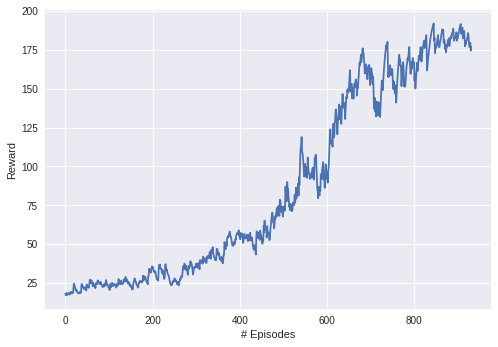

KeyboardInterrupt: ignored

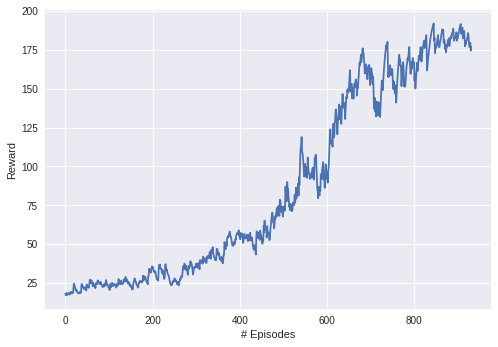

In [19]:
def plot_progress(x):
  plt.cla()
  plt.plot(x)
  plt.xlabel('# Episodes'); plt.ylabel('Reward')
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())


cartpole_model = create_cartpole_model()
MAX_ITERS = 1000
alpha = 0.9

smoothed_reward = []
tic = time.time()
for i_episode in range(MAX_ITERS):

  if time.time()-tic > 5: #plot every 5 seconds
      plot_progress(smoothed_reward)
      tic = time.time()

  # Restart the environment
  observation = env.reset()

  while True:
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      memory.add_to_memory(observation, action, reward)

      if done:
          total_reward = sum(memory.rewards)
          smoothed_reward.append( alpha*smoothed_reward[-1] + (1-alpha)*total_reward if len(smoothed_reward)>0 else total_reward )

          train_step(cartpole_model, 
                     optimizer, 
                     observations = np.vstack(memory.observations),
                     actions = np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          memory.clear()
          break

      observation = next_observation

### 1.6 Save a video of the trained model while it is balancing the pole

In [20]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
  import skvideo.io
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(40, 30))
  display.start()

  env = gym.make(env_name)
  obs = env.reset()
  shape = env.render(mode='rgb_array').shape[0:2]

  out = skvideo.io.FFmpegWriter("agent2.mp4")

  done = False
  while not done: 
      frame = env.render(mode='rgb_array')
      out.writeFrame(frame)
      
      action = model(tf.convert_to_tensor(obs.reshape((1,-1)), tf.float32)).numpy().argmax()
      obs, reward, done, info = env.step(action)
  out.close()
  print "Successfully saved into {}!".format(filename)

save_video_of_model(cartpole_model, "CartPole-v0")

Successfully saved into agent.mp4!


### 1.7 Display the saved video

In [21]:
from IPython.display import HTML
import io, base64
video = io.open('./agent2.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

Congratulations, well done!

## Pong